
This is my submission for the Project 4: Advanced Lane Finding for the Udacity Self-Driving Car NanoDegree Program.
Kelly Smith
Janurary 25, 2017


In [1]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os.path

In [2]:
"""
Define constants for pipeline
"""

# Camera Calibration filename 
calibrationFilename = "CameraCalibration.p"

# Limit to the amount of change in the x-coordinate of the peak from one row to the next. 
dxLim = 100 # pixels

# Define constants for lane detection logic
sufficientHits = 500 # Minimum number of activated pixels within a region required for   
numYBins=10

# Warping Source Points
warpSrcPoints = np.float32([ [545, 450], [725, 450], [1280, 720], [0, 720] ])

# Warp Destination Points
imgShape = [720, 1280]
inset = 100
warpDstPoints = np.float32([ [inset,0], [imgShape[1]-inset, 0], 
    [imgShape[1]-inset,imgShape[0]], [inset,imgShape[0]] ])

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

# -- Deprecated -- This defines thresholds (min, max) for my `create_binary_img` function (since un-used) 
thresholds = {'SobelX':[0, 255], 'hls':[100, 255]}

In [3]:
"""
This is my setup routine that loads the existing camera calibration matrix 
and the matrix for performing the perspective transform  
"""
def setup(Recalibrate=False):
    # Obtain camera coeffiicents
    mtx, dist = get_camera_calibration_data(Recalibrate)

    # Get perspective transform matrix M
    M = get_perspective_transform([720, 1280])
    return mtx, dist, M

In [5]:
"""
Manager function that either calibrates or loads existing calibration data if it exists
"""
def get_camera_calibration_data(Recalibrate, Debug=False):
    # Calibrate the camera, if commanded by the user or if no pickled data exists.
    if Recalibrate or not os.path.isfile(calibrationFilename):
        if Debug: 
            print("Calibrating camera...",end='')
        chessBoardSize = (9,6)
        mtx, dist = calibrateCamera(chessBoardSize)
        if Debug:
            print("Complete!")
            print("mtx = " + str(mtx))
            print("dist = " + str(dist))

        calibration_test(mpimg.imread('camera_cal/calibration10.jpg'), mtx, dist)
        
    else:
        if Debug:
            print("Loading existing caliberation data...", end='')
        x = loadCalibrationData()
        mtx = x['mtx']
        dist = x['dist']
        if Debug:
            print("Complete!")
    return mtx, dist

In [6]:
"""
Code to calibrate the camera (computing distortion coefficients).
I wrote this original code in just a text file and copy-pasted it 
into this notebook; the pasting appears to have introduced a weird tab/spacing issue.
"""
def calibrateCamera(chessBoardSize):
	

	images = glob.glob('camera_cal/calibration*.jpg')
	# images = glob.glob('calibration_wide/GOPR*.jpg')

	objpoints = []
	imgpoints = []

	objp = np.zeros((chessBoardSize[0]*chessBoardSize[1],3), np.float32)
	objp[:,:2] = np.mgrid[0:chessBoardSize[0], 0:chessBoardSize[1]].T.reshape(-1,2) # x, y coordinates

	ctr = 1
	n = len(images)
	for filename in images:
		print("(%d/%d)" % (ctr, n))
		ctr += 1
		# read in each image
		img = mpimg.imread(filename)

		# Convert to grayscale
		gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

		# Find chessboard corners
		ret, corners = cv2.findChessboardCorners(gray, chessBoardSize, None)

		if ret == True:
			imgpoints.append(corners)
			objpoints.append(objp)
		else:
			print("WARNING: Calibration on %s failed." % (filename))

	# Calibrate the camera
	ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

	# Save the camera calibration data
	saveCalibrationData(mtx, dist, rvecs, tvecs)
	
	# Return the Camera matrix (mtx) and Distortion Coefficients (dist)
	return (mtx, dist)

In [7]:
"""
Serialize the camera calibration data via pickle.
"""
def saveCalibrationData(mtx, dist, rvecs, tvecs):
	x = {"mtx":mtx, "dist":dist}
	# calibrationFilename = "CameraCalibration.p"
	with open (calibrationFilename,"wb") as output_file:
		pickle.dump(x, output_file)
		print("Saved the Camera Calibration data to %s" % calibrationFilename)

In [8]:
"""
Loads serialized camera calibration data from pickle file.
"""
def loadCalibrationData():
	with open (calibrationFilename,"rb") as input_file:
		x = pickle.load(input_file)
	return x

## Undistort Demonstration
The cell below demonstrates the camera calibration on one of the camera calibration images.  Note that the original image bows near the top of the checkerboard pattern and that the undistorted image eliminates this radial distortion.

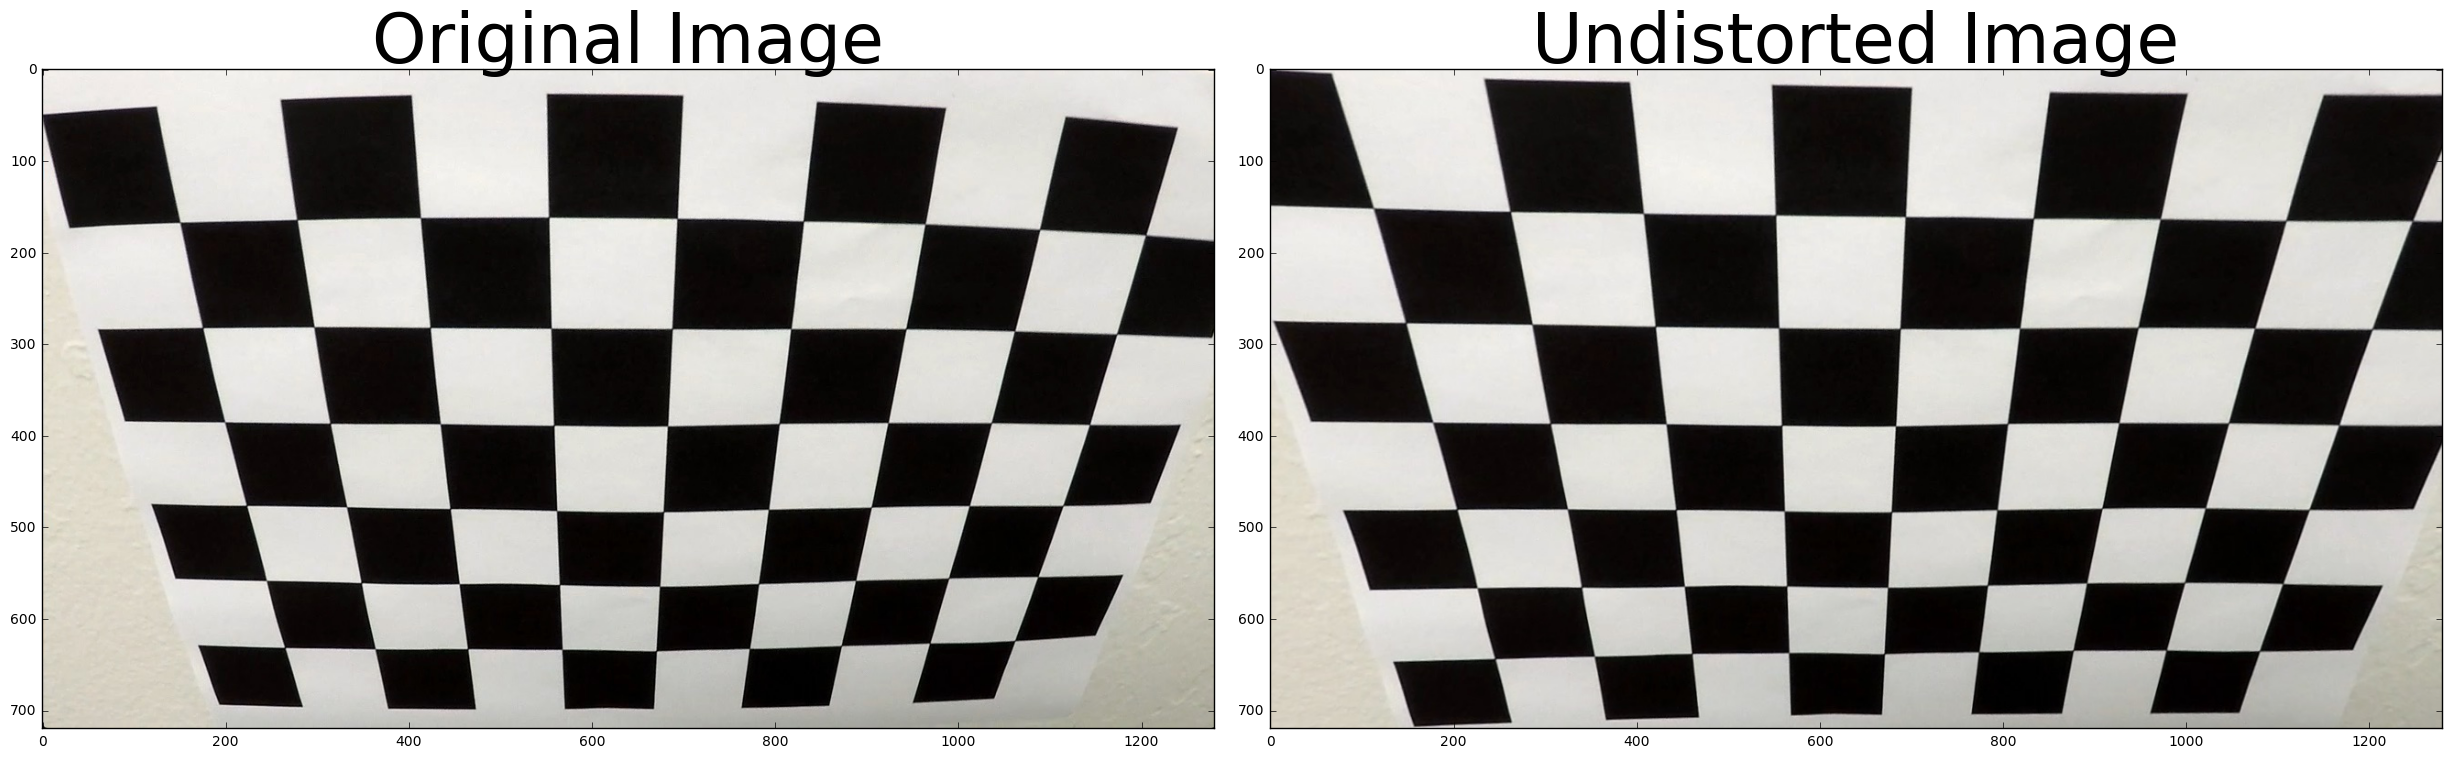

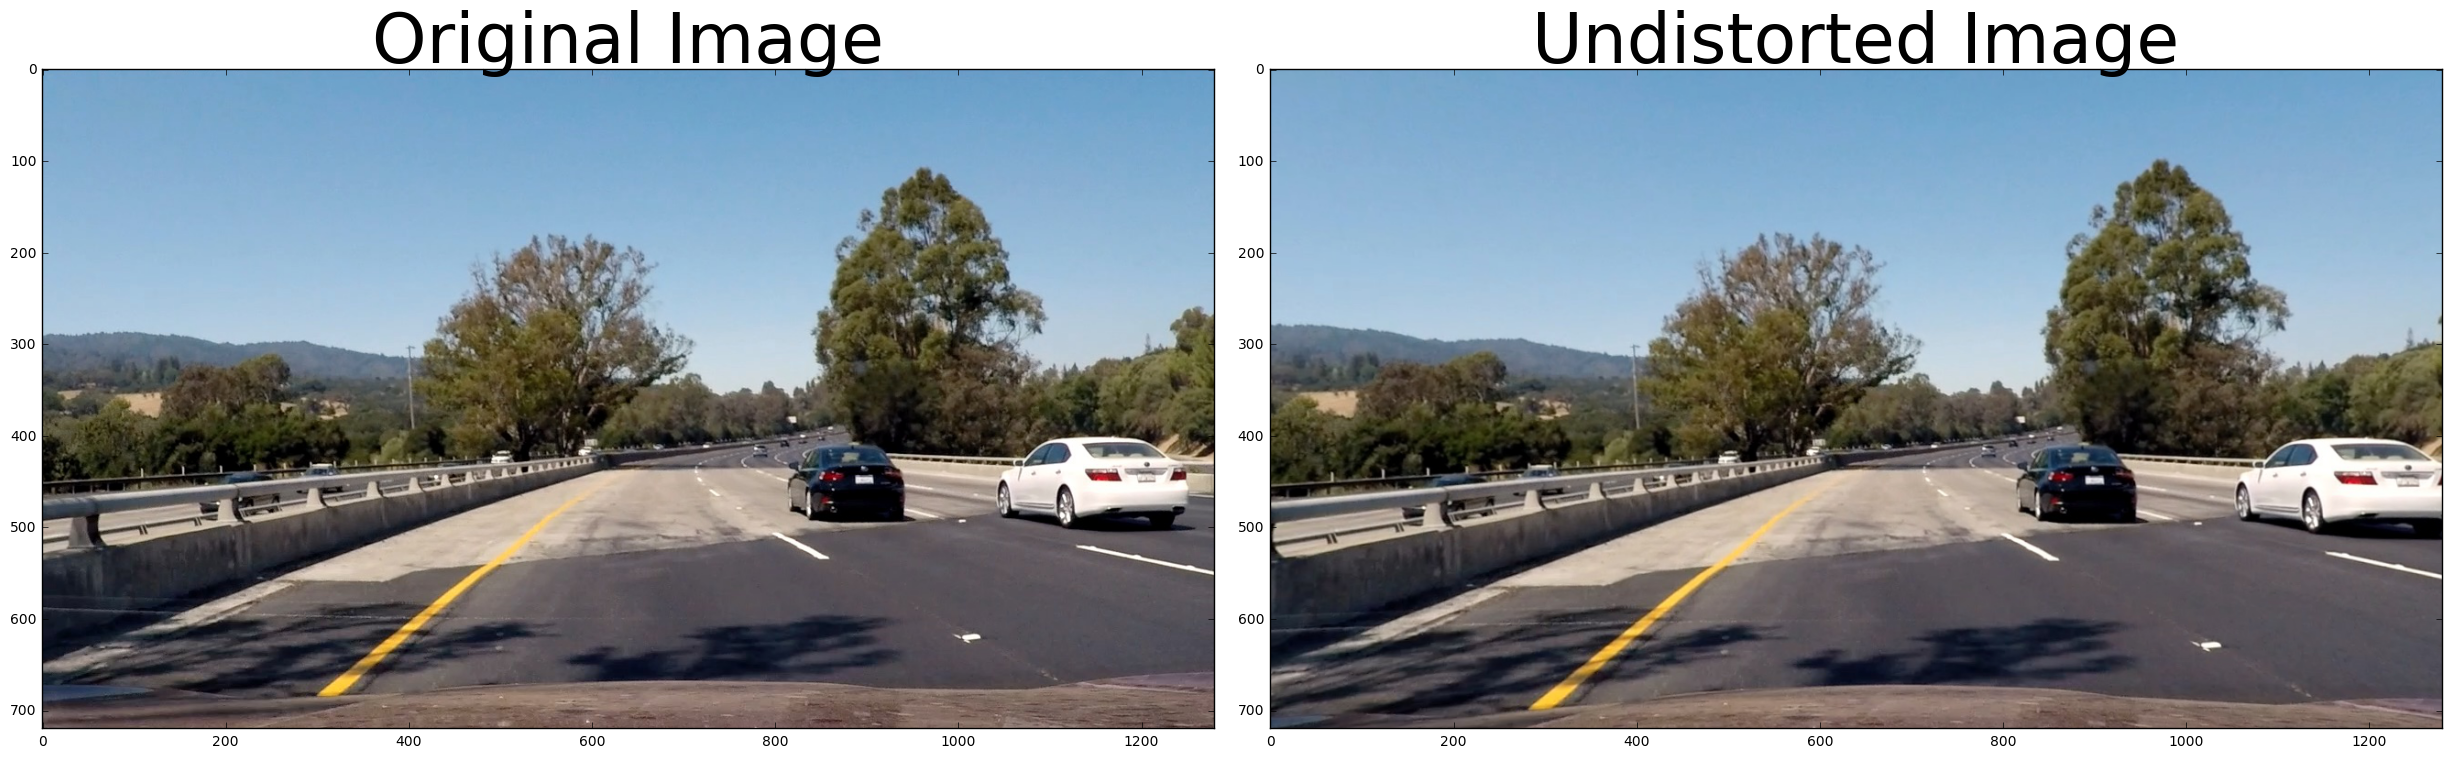

In [88]:
"""
This function undistorts a test image and plots the original and undistorted images.
"""
def calibration_test(img, mtx, dist):
	undistorted = undistort_img(img, mtx, dist)

	f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
	f.tight_layout()
	ax1.imshow(img)
	ax1.set_title('Original Image',fontsize=50)
	ax2.imshow(undistorted)
	ax2.set_title('Undistorted Image', fontsize=50)
	plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
	plt.show()
    
# Load the existing undistortion parameters
mtx, dist, M = setup()

# Load the image
img = mpimg.imread('camera_cal/calibration2.jpg')

# Run the calibration test
calibration_test(img, mtx, dist)
calibration_test(mpimg.imread('test_images/test4.jpg'), mtx, dist)

## Pipeline utilities
The functions below are many of the utility functions that are used to handle each step of the image processing pipeline.

In [10]:
"""
Undistort the image using camera calibration.
"""
def undistort_img(img, mtx, dist):
	undistorted = cv2.undistort(img, mtx, dist, None, mtx)
	return undistorted

In [11]:
"""
This was my attempt to create a thresholded binary image.  I experimented with 
Sobel-x edge detection, magnitude of Sobel-x and Sobel-y, and using the Saturation layer
from an HLS representation of the image.

Ultimately, I did not use this function because I found the Udacity-provided thresholding function
to be more robust. The Udacity version also included fewer false positives.

"""
def create_binary_img(img, thresholds):
    # Use color transforms, gradients to get thresholded binary image
    
    # Layers
    # 1. Grayscale Sobel-x edge detection
    # 2. Directed edge detetions
    # 3. RSS of Sobel-x and Sobel-y
    # 4. Image Saturation layer

    # Convert to grayscale
    
    # raw_sobelx = sobelx(img)
    # Apply thresholds
    # binary_sobelx = raw_sobelx
    # binary_sobelx = np.zeros_like(raw_sobelx)
    # binary_sobelx[(binary_sobelx >= thresholds['SobelX'][0]) & (binary_sobelx <= thresholds['SobelX'][1])] = 1

    binary_hls = hlsSelect(img, thresholds['hls'])
    binary_sobel = mag_thresh(img)

    # Perform Sobel-x and take absolute value to find edges
    # sobelx8 = sobelx(gray)

    # Apply threshold
    # sxbinary = np.zeros_like(sobelx8)
    # sxbinary[(sobelx8 >= thresholds[0]) & (sobelx8 <= thresholds[1])] = 1

    # Merge layers
    # merged_binary = cv2.bitwise_or(binary_hls, binary_sobel)
    merged_binary = np.zeros_like(img)
    merged_binary[(binary_hls==1)] = 1 # | (binary_sobel==1)] = 1
    
    # combined_binary = np.zeros_like(sxbinary)
    # combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1


    return merged_binary

In [13]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [72]:
"""
Saturation layer thresholding from HLS color image.  Re-used from lectures.
"""
def hlsSelect(img, thresholds):
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]

	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresholds[0]) & (s_channel <= thresholds[1])] = 1
	return binary_output

"""
Sobel-x algorithm, taken from lectures.
"""
def sobelx(img):
	# Perform Sobel-x and take absolute value to find edges
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	sobelx_raw = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
	# Convert to 8-bit
	return np.uint8(255*sobelx_raw/np.max(sobelx_raw))

"""
Sobel-y edge detection algorithm, taken from lectures
"""
def sobely(img):
	# Perform Sobel-x and take absolute value to find edges
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	sobely_raw = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
	# Convert to 8-bit
	return np.uint8(255*sobely_raw/np.max(sobely_raw))


"""
Function to return the magnitude of the gradient in X & Y, taken from lectures.
"""
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    # binary_output = np.zeros_like(gradmag)
    # binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return gradmag

# Create binary image from color thresholding and edge detection

In [12]:
"""
This is the Udacity-provided binary image thresholding algorithm, taken from the lecture material.
I modified it slightly and adjusted some thresholds to help tune it to handle 
challenging scenarios.
"""
def udacity_binary_img(img, Debug=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    # Threshold color channel
    s_thresh_min = 120 # 170 <- udacity original
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    if Debug:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        plt.show()
    return combined_binary

## Color Thresholding Experimentation
This is where I tested the thresholding algorithms on images and adjusted tuning.

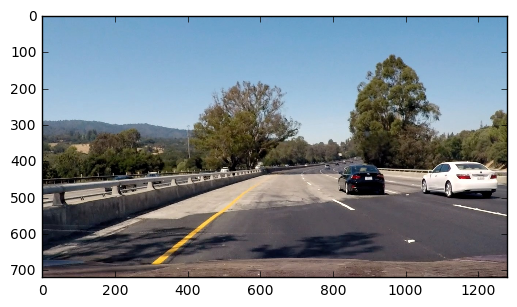

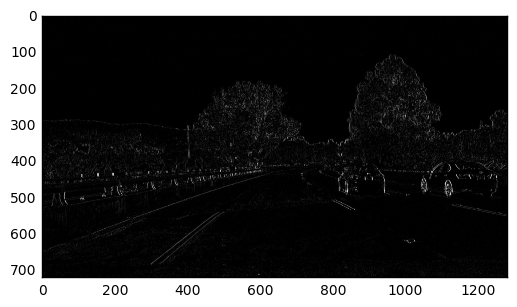

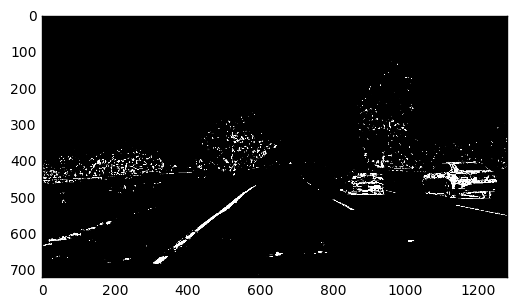

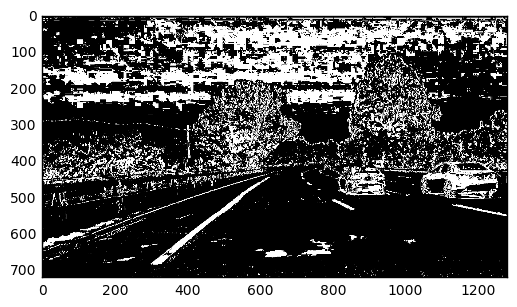

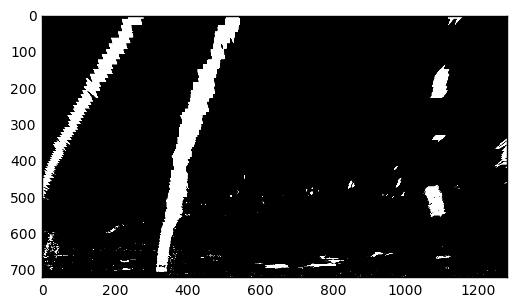

In [90]:
"""
Test create_binary_img algorithm
"""
img = mpimg.imread("test_images/test4.jpg")

# Resize all images for consistency
img = cv2.resize(img, (1280,720))

# Display original image
plt.imshow(img)
plt.show()

# Display Sobel-x (grayscale)
sobelxImg = sobelx(img)
plt.imshow(sobelxImg,cmap='gray')
plt.show()

# Display output of HLS img
hlsImg = hlsSelect(img, thresholds['hls'])
plt.imshow(hlsImg, cmap='gray')
plt.show()

#Display oriented gradient
# dirImg = dir_threshold(img, sobel_kernel=15, thresh=(-0.3,0.3)) #1.2))
# plt.imshow(dirImg,cmap='gray')
# plt.show()

# Display Merged Binary
#binImg = create_binary_img(img, thresholds)
#plt.imshow(binImg,cmap='gray')
#plt.show()

udBinImg = udacity_binary_img(img)
plt.imshow(udBinImg,cmap='gray')
plt.show()

M = get_perspective_transform([720, 1280])
warped = transform_perspective(udBinImg, M, (1280,720))# udBinImg.shape[::-1])
plt.imshow(warped,cmap='gray')
plt.show()

In [55]:
"""
Obtain the perspective transformation matrix given the source and destination points
"""
def get_perspective_transform(imgShape):
    M = cv2.getPerspectiveTransform(warpSrcPoints, warpDstPoints)
    return M

In [92]:
"""
Perform image warping to convert image to/from bird's eye view.
"""
def transform_perspective(img, M, dest_img_size):
    # Transform image to birds-eye-view
    warped = cv2.warpPerspective(img, M, dest_img_size)
    return warped

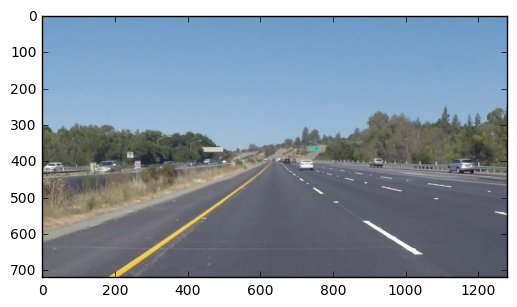

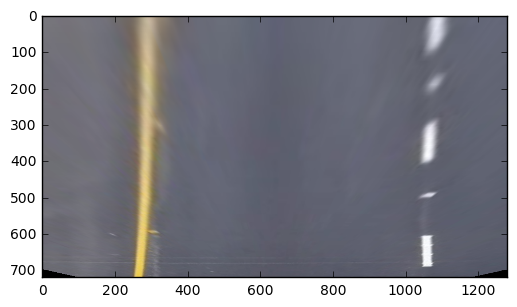

In [107]:
img = mpimg.imread('test_images/solidYellowLeft.jpg')

# Resize image for consistency
img = cv2.resize(img, (1280,720))

warped = transform_perspective(img, M, (1280, 720))
plt.imshow(img)
plt.show()
plt.imshow(warped)
plt.show()

In [20]:
"""
Function to compute lane curvature in real-space, where the output is 
reported in meters, using the empirical conversion provided by Udacity.
This algorithm is re-used from the lecture material.
"""
def computeLaneCurvature(laneLines, Debug=False):
    # Define conversions in x and y from pixels space to meters
    
    leftLane = laneLines[0]
    rightLane = laneLines[1]
    
    # Fit a quadratic polynomial to the left and right images.
    leftFit = np.polyfit(leftLane[:,1]*ym_per_pix, leftLane[:,0]*xm_per_pix, 2)
    rightFit = np.polyfit(rightLane[:,1]*ym_per_pix, rightLane[:,0]*xm_per_pix, 2)
    
    # Define the point about which the radius of curvature is defined.
    y_eval = np.max(leftLane[:,1])
    
    left_curve_radius = ((1 + (2*leftFit[0]*y_eval + leftFit[1])**2)**1.5) \
                                 /np.absolute(2*leftFit[0])
    right_curve_radius = ((1 + (2*rightFit[0]*y_eval + rightFit[1])**2)**1.5) \
                                    /np.absolute(2*rightFit[0])
    
    if Debug:
        print(left_curve_radius, 'm', right_curve_radius, 'm')
    return [[left_curve_radius, right_curve_radius], [leftFit, rightFit]]
    
"""
Function to compute lane curvature in pixel-space, where the output is 
reported in pixels. This algorithm is re-used from the lecture material.
"""
def computeLaneCurvaturePx(laneLines, Debug=False):
    leftLane = laneLines[0]
    rightLane = laneLines[1]
    
    leftFit = np.polyfit(leftLane[:,1], leftLane[:,0], 2)
    rightFit = np.polyfit(rightLane[:,1], rightLane[:,0], 2)
    
    y_eval = np.max(leftLane[:,1])
    
    left_curve_radius = ((1 + (2*leftFit[0]*y_eval + leftFit[1])**2)**1.5) \
                                 /np.absolute(2*leftFit[0])
    right_curve_radius = ((1 + (2*rightFit[0]*y_eval + rightFit[1])**2)**1.5) \
                                    /np.absolute(2*rightFit[0])
    
    if Debug:
        print(left_curve_radius, 'px', right_curve_radius, 'px')
    return [[left_curve_radius, right_curve_radius], [leftFit, rightFit]]

In [57]:
"""
Function to compute position error.  This is done by simply measuring the lane 
width between the detected lanes at the point nearest to the camera.
Then, this computed lane center is compared to half the width of the image.
The difference between the computed lane center to the image width/2 is the 
position error.
"""
def computePositionError(lanes, imgWidth, Debug=False):
    
    left = lanes[0]
    right = lanes[1]
    
    xLaneCenter = (right[0][0] + left[0][0]) / 2
    
    if Debug:
        print("ImgWidth = %d" % (imgWidth))
        print("X-Lane Center = %d px" % (xLaneCenter))
    
    # Compute the difference between the computed lane center and the center of image.
    positionErrorPx = xLaneCenter - imgWidth/2
    
    # Convert the pixel difference into real-space (meters)
    posError = positionErrorPx * xm_per_pix
    return posError, positionErrorPx


In [22]:
"""
Unwarps a bird's eye view image the road.
"""
def unwarpImg(img):
    # Get the matrix transformation from the warped space to unwarped space. 
    M_unwarp = cv2.getPerspectiveTransform(warpDstPoints, warpSrcPoints)
    
    # Unwarp the image.
    unwarpedImg = transform_perspective(img, M_unwarp, (img.shape[1], img.shape[0]))
    return unwarpedImg

"""
Generates the lane overlay to superimpose on the original image. 
"""
def makeOverlay(imgShape, leftLane, rightLane, posError, Debug=False):
    
    # Initialize with black screen.
    overlay = np.zeros((imgShape[0], imgShape[1], 3), dtype=np.uint8)
    
    # Create set of polygon vertices.  The order is left, then reversed(right).
    polygon = np.int32(np.concatenate((leftLane, rightLane[::-1]),axis=0))
    
    # Draw the lane with a green color.
    cv2.fillPoly(overlay, np.int32([polygon]), (0, 255, 0))

    if Debug:
        plt.imshow(overlay,cmap='gray')
        plt.show()

    return overlay
    

# Executive Pipeline Function
The function below assembles all the functions into a sequence of execution to 
identify the left and right lane lines.

In [108]:
"""
This is the MAIN pipeline for processing an image.
"""
def processImg(img, mtx, dist, M, thresholds, Debug=False):
    
    # Undistort the image
    undistortedImg = undistort_img(img, mtx, dist)

    # Apply thresholding (color transforms, gradients) to obtain binary image
    thresholded = udacity_binary_img(img, Debug)
    
    # Warp the image with a perspective transform into the bird's eye view (top-down)
    birdsEyeView = transform_perspective(thresholded, M, (thresholded.shape[1], thresholded.shape[0]))

    # Identify the lane pixels in the bird's eye view image
    lanes = findLanePixels(birdsEyeView, Debug)

    # Print the lanes, if in Debug mode.
    if Debug:
        print('--- Lanes ---')
        print(lanes)
    
    # Compute the position error (off centerline)
    posError, posErrorPx = computePositionError(lanes, birdsEyeView.shape[1])
    
    # Print the position error solution, if in Debug mode.
    if Debug:
        print("Pos Error = %f m (%d px)"% (posError, posErrorPx))
    
    # Compute the lane curvature in real-space and in pixel space.
    outputM  = computeLaneCurvature(lanes)
    outputPx = computeLaneCurvaturePx(lanes)
    
    # Store the real-space curvature for later display
    curvature = outputM[0]
    
    # Store the quadratic fit of the left and right lanes from the pixel space lanes.
    fits = outputPx[1]
    
    # Generate the curves for the quadratic fits for the left and right lanes.
    leftFit = fits[0]
    rightFit = fits[1]
    
    y = np.linspace(0,birdsEyeView.shape[0],100)
    leftFitX = leftFit[0]*y**2 + leftFit[1]*y + leftFit[2]
    rightFitX = rightFit[0]*y**2 + rightFit[1]*y + rightFit[2]
    
    # If in Debug mode, plot the polynomial lane solutions (pixel-space).
    if Debug:
        print("Left Fit")
        print(leftFit)
        print("Right Fit")
        print(rightFit)
    
        plt.plot(leftFitX, y,'-r',linewidth=5)
        plt.plot(rightFitX,y,'-g',linewidth=5)
        plt.gca().invert_yaxis()
        plt.ylim((0,720))
        plt.xlim((0,1280))
        plt.show()
    
    # Convert these coordinates to numpy arrays.
    left = []
    right = []
    for i in range(len(leftFitX)):
        left.append([leftFitX[i],y[i]])
        right.append([rightFitX[i],y[i]])
    left = np.asarray(left)
    right = np.asarray(right)
    
    # Generate overlay to superimpose on the image.
    overlay = makeOverlay(birdsEyeView.shape, left, right, posError)
    
    # Warp the overlay from bird's eye view into the original view.
    unwarpedOverlay = unwarpImg(overlay)
    
    # Combine the overlay with the original image.
    origImgWithOverlay = cv2.addWeighted(img, 1.0, unwarpedOverlay, 0.2, 0)
    
    # Draw text on the screen (in unwarped image space).  Show position error and left/right curvature values.
    font = cv2.FONT_HERSHEY_SIMPLEX
    posErrorString = "Pos Error = %6.2f m" % (posError)
    cv2.putText(origImgWithOverlay, posErrorString,(50,50), font, 1, (255,255,255),2)
    
    leftLaneCurvStr = "Left Curv = %6.2f m" % (curvature[0])
    rightLaneCurvStr = "Right Curv = %6.2f m" % (curvature[1])
    cv2.putText(origImgWithOverlay, leftLaneCurvStr,(50,100), font, 1, (255,255,255),2)
    cv2.putText(origImgWithOverlay, rightLaneCurvStr,(50,150), font, 1, (255,255,255),2)
    

    # If in Debug mode, create a series of plots to visualize intermediate processing
    # outputs.  This aids in troubleshooting issues in the pipeline.
    if Debug:
        plt.imshow(origImgWithOverlay)
        plt.show()

        # Plot results
        f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,9))
        f.tight_layout()
        ax1.imshow(img)
        for i in range(len(warpSrcPoints)):
            ax1.plot(warpSrcPoints[i][0], warpSrcPoints[i][1],'.')

        ax1.set_title('Original Image',fontsize=50)
        ax2.imshow(thresholded, cmap='gray')
        ax2.set_title('Thresholded', fontsize=50)
        ax3.imshow(birdsEyeView, cmap='gray')
        for i in range(len(warpSrcPoints)):
            ax3.plot(warpDstPoints[i][0], warpDstPoints[i][1],'.')
        ax3.set_title('Birds Eye View', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        for i in range(len(lanes)):
            for j in range(2):
                ax3.plot(lanes[i][j][0], lanes[i][j][1],'s')
        plt.show()
    
    return origImgWithOverlay

# Lane Pixel Identification
The code below `findLanePixels()` identifies a series of points from the binary images that are used to fit a polynomial. 

In [82]:
"""
Identify points along the detected lane pixels to be used in fitting polynomials.
"""
def findLanePixels(img, Debug=False):
    
    # Coarse peak identification: Compute a histogram of the lower half of the image.
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

    # Identify the peak points in the histogram in the left and 
    # right point halves of the histogram.
    xSplit = len(histogram)/2
    leftPeak = np.argmax(histogram[:xSplit])
    rightPeak = np.argmax(histogram[xSplit:])+xSplit
    
    # If in Debug mode, print the coarse solution.
    if Debug:
        print("----- COARSE -------")
        print("Left peak is at %d" % (leftPeak))
        print("Right peak is at %d" % (rightPeak))
    
    # Define the search window for subsequent pixels.
    windowWidth = img.shape[1] / 5

    # Divide the image into horizontal stripes to search.
    yBins = np.linspace(img.shape[0], 0, numYBins)

    # If in Debug mode, show the binary image in top-down view.
    if Debug:
        print("------ FINE --------")
        plt.imshow(img,cmap='gray')
    
    # Initialize the arrays that will store the lane points.
    windowPeak = []
    leftLaneMarker = []
    rightLaneMarker = []
    
    # For each horizontal stripe in the image
    for i in range(numYBins-1):

        # Define y-bounds for search window
        yMax = yBins[i+1]
        yMin = yBins[i]

        ######
        # Perform search for left lane pixels
        ######
        xMin = max([leftPeak - windowWidth/2, 0])
        xMax = xMin + windowWidth
        
        # Compute the histogram of the smaller search window.
        hist = np.sum(img[yMax:yMin,xMin:xMax],axis=0)
        
        # If in Debug mode, plot the search window as a red square.
        if Debug:
            plt.plot([xMin, xMax, xMax, xMin, xMin], 
                     [yMax, yMax, yMin, yMin, yMax],'-rs')
            
        # Count the number of activated pixels in the search window
        leftHits = sum(hist)
        
        # If there are enough hits to register a real lane marker
        if (leftHits > sufficientHits): # or len(leftLaneMarker)==0:
            # Then identify the candidate peak x-coordinate.
            candidatePeak = np.argmax(hist) + xMin
            
            # Measure how far separated the proposed candidate pixel 
            # is from the previous point.
            dx = candidatePeak - leftPeak
            
            if Debug:
                print("RIGHT: Proposed moving %d px" % (dx))
            
            # If the proposed move is more than 75 pixels away, then 
            # constrain the update to just 75 pixels.
            if abs(dx) > 75:
                leftPeak = leftPeak + np.sign(dx)*75
            else:
                # Otherwise, do not constrain the update.
                leftPeak = candidatePeak
            
            # Store the left peak X and Y coordinates.
            leftLaneMarker.append([leftPeak, (yMax+yMin)/2.0])
        else:
            # No, there weren't enough lane pixels activated within the search window.
            # This suggests that:
            #  1) there either isn't a lane marker in this stripe, OR
            #  2) the algorithm has lost track of the lane.
            
            # I attempted to implement clever fall-back code, but it typically caused
            # more trouble than it was worth.  As a result, I just keep the previous
            # leftPeak value and duplicate it.
            
            leftLaneMarker.append([leftPeak, (yMax+yMin)/2])
            
            """
            # Print diagnostic message for troubleshooting.
            if Debug:
                print("LEFT: Could not find enough pixels, expanding search")
                
            # Compute a histogram of left half of the horizontal stripe of this image (expanded search area)
            hist = np.sum(img[yMax:yMin,:xSplit], axis=0)
            
            # Count the number of hits.
            leftHits = np.sum(hist) 
            
            # If we have enough hits, then it suggests we've lost track of the original lane, 
            # and the activated lane pixels are outside the original search window.
            if leftHits >= 1000:
                # leftPeak = np.argmax(hist)
                if Debug:
                    print("Got %d hits in expanded search (LEFT)" % (leftHits))
                    #print("LEFT: Detected Left Lane at x = %d" % (leftPeak))
            elif Debug:
                print("LEFT: Failed to re-detect lane.  Output stale X.")
            
            leftLaneMarker.append([leftPeak, (yMax+yMin)/2])
            """
            
        # If in Debug mode, plot the solution point with a yellow dot.
        if Debug:
            plt.plot(leftPeak, (yMax+yMin)/2,'yo')
        
        ########
        # Right lane finding algorithm (duplicate of left with minor changes)
        ########
        
        # Form the x-bounds of the right lane search window
        xMax = min([rightPeak + windowWidth/2, img.shape[1]])
        xMin = xMax - windowWidth
        
        # If in Debug mode, plot the search window
        if Debug:
            plt.plot([xMin, xMax, xMax, xMin, xMin], 
                     [yMax, yMax, yMin, yMin, yMax],'-rs')
        
        
        # Compute the histogram of the right search window.
        hist = np.sum(img[yMax:yMin, xMin:xMax], axis=0)
        
        # Count the number of activated pixels within the search window.
        rightHits = sum(hist)
        
        # If the number of activated pixels within the search window exceeds a threshold
        if (rightHits > sufficientHits):
            # Then performed a constrained update to the right peak (<=75px updates permitted)
            candidatePeak = np.argmax(hist) + xMin
            dx = candidatePeak - rightPeak
            if Debug:
                print("RIGHT: Proposed moving %d px" % (dx))
            if abs(dx) > 75:
                rightPeak = rightPeak + np.sign(dx)*75
            else:
                rightPeak = candidatePeak
            
            rightLaneMarker.append([rightPeak, (yMax+yMin)/2])
        else:
            
            # Similar to left logic, just record the previous rightPeak value
            rightLaneMarker.append([rightPeak, (yMax+yMin)/2])
            
            # Below is the deprecated logic.
            """
            # Insufficient pixels detected... so expand search window to right half of image 
            FoundLane = False
            if Debug:
                print("RIGHT: Could not find enough pixels, expanding search")
            hist = np.sum(img[yMax:yMin,xSplit:], axis=0)
            
            rightHits = np.sum(hist) 
            if rightHits >= 1000:
                # rightPeak = np.argmax(hist)+xSplit
                if Debug:
                    print("Got %d hits in expanded search (RIGHT)" % (np.sum(hist)))
                    print("RIGHT: Detected Right Lane at x = %d" % (rightPeak))
                
            elif Debug:
                print("RIGHT: Failed to re-detect lane.  Output stale X.")
            rightLaneMarker.append([rightPeak, (yMax+yMin)/2])
            """
            
        
        if Debug:
            plt.plot(rightPeak, (yMax+yMin)/2,'yo')
        
        if Debug:
            print("-- Box %d --" % (i))
            print("Left X = %d (%d hits)" % (leftPeak, leftHits))
            print("Right X = %d (%d hits)" % (rightPeak, rightHits))
        
        
        
    # Convert from lists to np arrays
    rightLaneMarker = np.asarray(rightLaneMarker)
    leftLaneMarker  = np.asarray(leftLaneMarker)
    plt.show()
    
    if Debug:
        print(leftLaneMarker)
        print(rightLaneMarker)
        
    return [leftLaneMarker, rightLaneMarker]

The cell below is where I test the pipeline on various image frames extracted from the video.

In [37]:
"""
Here is my test function to process a single image.  
"""

def test(testImg, Debug=False):
    img = mpimg.imread(testImg)

    mtx, dist, M = setup()
    
    # Resize all images for consistency
    img = cv2.resize(img, (1280,720))
    if Debug:
        print(img.shape)
            
    # Process image using pipeline 
    imgOut = processImg(img, mtx, dist, M, thresholds, Debug)
    plt.imshow(imgOut)
    plt.show()

(720, 1280, 3)


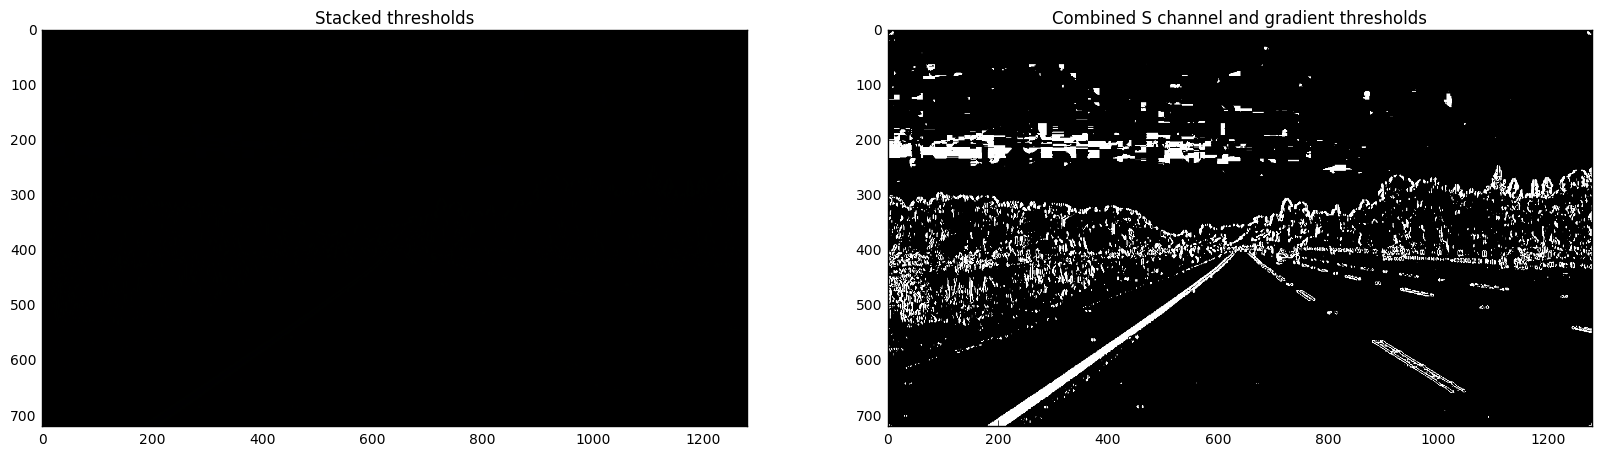

----- COARSE -------
Left peak is at 262
Right peak is at 1064
------ FINE --------
RIGHT: Proposed moving -7 px
RIGHT: Proposed moving -15 px
-- Box 0 --
Left X = 255 (2711 hits)
Right X = 1049 (937 hits)
RIGHT: Proposed moving 4 px
RIGHT: Proposed moving -1 px
-- Box 1 --
Left X = 259 (3333 hits)
Right X = 1048 (829 hits)
RIGHT: Proposed moving 2 px
-- Box 2 --
Left X = 261 (3720 hits)
Right X = 1048 (463 hits)
RIGHT: Proposed moving 0 px
-- Box 3 --
Left X = 261 (3994 hits)
Right X = 1048 (313 hits)
RIGHT: Proposed moving 1 px
RIGHT: Proposed moving -12 px
-- Box 4 --
Left X = 262 (4474 hits)
Right X = 1036 (2826 hits)
RIGHT: Proposed moving -2 px
RIGHT: Proposed moving 53 px
-- Box 5 --
Left X = 260 (5225 hits)
Right X = 1089 (1359 hits)
RIGHT: Proposed moving -2 px
RIGHT: Proposed moving -13 px
-- Box 6 --
Left X = 258 (5361 hits)
Right X = 1076 (2677 hits)
RIGHT: Proposed moving -1 px
RIGHT: Proposed moving -33 px
-- Box 7 --
Left X = 257 (5680 hits)
Right X = 1043 (1602 hits)
RI

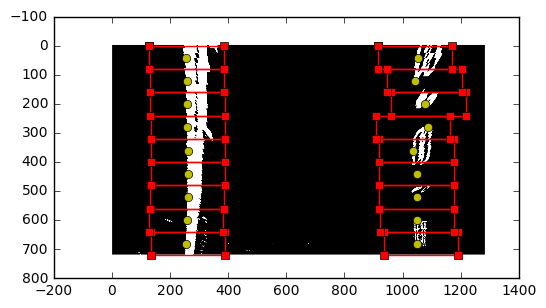

[[ 255.  680.]
 [ 259.  600.]
 [ 261.  520.]
 [ 261.  440.]
 [ 262.  360.]
 [ 260.  280.]
 [ 258.  200.]
 [ 257.  120.]
 [ 254.   40.]]
[[ 1049.   680.]
 [ 1048.   600.]
 [ 1048.   520.]
 [ 1048.   440.]
 [ 1036.   360.]
 [ 1089.   280.]
 [ 1076.   200.]
 [ 1043.   120.]
 [ 1053.    40.]]
--- Lanes ---
[array([[ 255.,  680.],
       [ 259.,  600.],
       [ 261.,  520.],
       [ 261.,  440.],
       [ 262.,  360.],
       [ 260.,  280.],
       [ 258.,  200.],
       [ 257.,  120.],
       [ 254.,   40.]]), array([[ 1049.,   680.],
       [ 1048.,   600.],
       [ 1048.,   520.],
       [ 1048.,   440.],
       [ 1036.,   360.],
       [ 1089.,   280.],
       [ 1076.,   200.],
       [ 1043.,   120.],
       [ 1053.,    40.]])]
Pos Error = 0.063429 m (12 px)
Left Fit
[ -6.51041667e-05   5.04166667e-02   2.51620833e+02]
Right Fit
[ -9.26677489e-05   4.63041126e-02   1.05373853e+03]


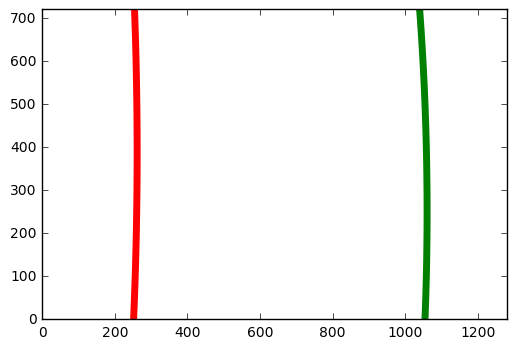

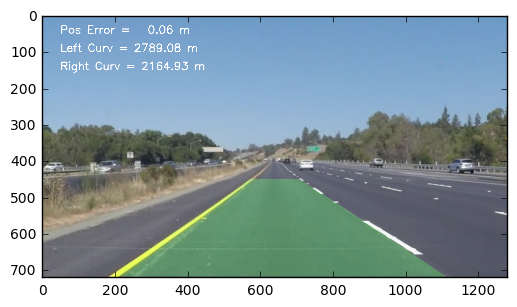

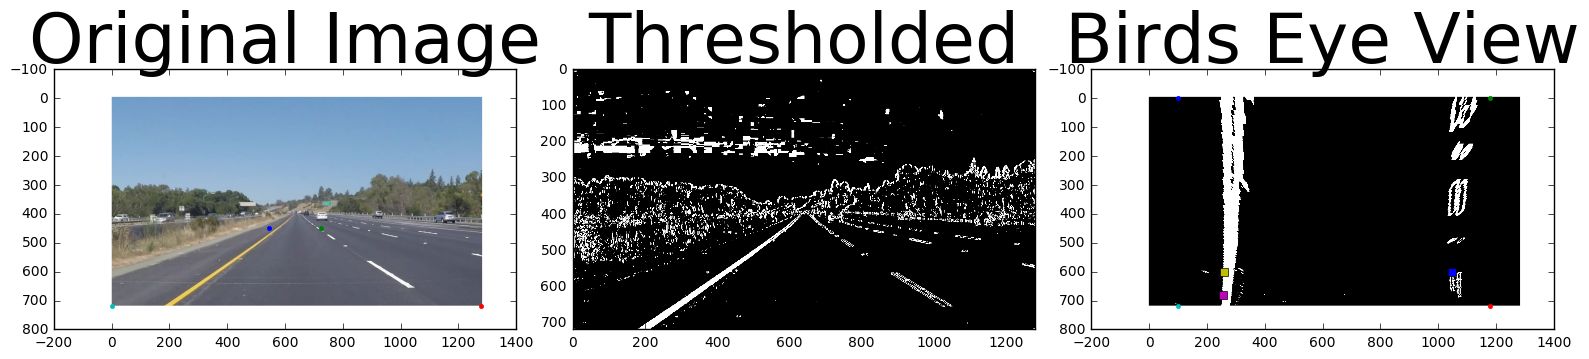

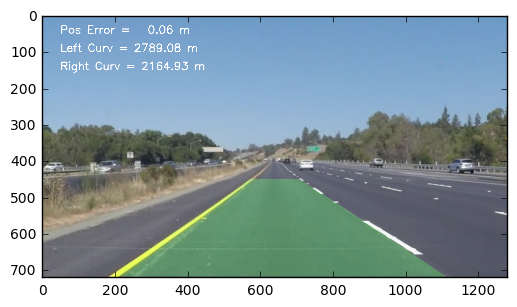

In [109]:
test("test_images/solidYellowLeft.jpg", Debug=True)
# test("test_images/solidWhiteRight.jpg", Debug=True)

# test("project_video_frames/frame10.jpg", Debug=True)
# test("project_video_frames/frame1025.jpg", Debug=True)
# test("project_video_frames/frame542.jpg", Debug=True)
# test("project_video_frames/frame609.jpg", Debug=True) # <- causes problems

# test("project_video_frames/frame1042.jpg", Debug=True)

# Video Processing
I re-used this code from Project 1 for processing video clips.

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    mtx, dist, M = setup()
    # thresholds = {'SobelX':[0, 255], 'hls':[100, 255]}
    result = processImg(image, mtx, dist, M, thresholds)
    return result

In [636]:
"""
Code snippet to extract every image from the video and save as a JPG image.  
This was used to obtain frames from the video that caused the pipeline trouble.
I found this code snippet on StackOverflow: 
http://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
"""
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
    count += 1
print("Complete!")

KeyboardInterrupt: 

In [84]:
white_output = 'submission.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video submission.mp4
[MoviePy] Writing video submission.mp4


100%|█████████▉| 1260/1261 [01:48<00:00, 11.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission.mp4 

CPU times: user 2min 44s, sys: 20 s, total: 3min 4s
Wall time: 1min 49s


In [85]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

